# LONG Yongkang

In [1]:
# import all needed resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import time
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
import requests
from torchvision import transforms, models


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.cuda.get_device_name()

'Tesla V100-SXM2-32GB'

In [4]:
def load_image(img_path, max_size = 400, shape = None):
    
    ''' Load and downscale an image if the shorter side is longer than <max_size> px '''
    
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    if min(image.size) > max_size:
        size = max_size
    else:
        size = min(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard alpha channel (:3) and append the batch dimension (unsqueeze(0))
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [5]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Convert a PyTorch tensor to a NumPy image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [6]:
def gram_matrix(tensor, normalize = False):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # TODO Task 1: Implement the computation of the Gram Matrix
    
    ## get the batch_size b, depth c, height h, and width w of the Tensor
    ## reshape it, so we're multiplying the features for each channel
    ## calculate the gram matrix
    b,c, h, w = tensor.size()
    tensor = tensor.view(b*c, h * w)
    gram = torch.mm(tensor, tensor.t())
    
    ## if normalize = True, normalize the gram matrix as it is done in Equation 3 of [5]
    if normalize == True:
         gram.div(b * c * h * w)
    #gram = None
    
    return gram

In [7]:
def get_features(image, model, layers):
    # Run an image forward through a model and get the features for a set of layers.
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [8]:
def result_to_hd(image, filePath):
    image = im_convert(image)

    formatted = (image * 255 / np.max(image)).astype('uint8')
    pil_image = Image.fromarray(formatted, 'RGB')
    pil_image.save(filePath, "JPEG")

# Perceptual Losses for Real-Time Style Transfer and Super-Resolution [5]

Instead of solving an optimization problem for each target image, Johnson et al. [5] train a feed forward neural network for style transfer. Your task now is to re-implement certain aspects of their method.

In [9]:
# Helper Functions and classes, you do not have to change anything here, you can however if these functions do not fully satisfy your needs

class ImageDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.total_imgs = os.listdir(root)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        return load_image(os.path.join(self.root, self.total_imgs[idx]))[0]
    
def get_checkpoint_dir(suffix = None):
    max_num = 0

    dirs = [os.path.basename(x[0]) for x in os.walk('checkpoints')]

    for dir in dirs:
        elems = dir.split('_')
        if len(elems) > 0:
            prefix = elems[0]

            if len(prefix) > 0 and all(map(str.isdigit, prefix)):
                num = int(prefix)

                if max_num <= num:
                    max_num = num + 1

    checkpoint_dir = os.path.join('checkpoints', str(max_num).zfill(5) + '_checkpoint_' + (suffix if not suffix == None else ''))

    return max_num, checkpoint_dir

def write_checkpoint(checkpoint_dir, model, optimizer, iter_number):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    torch.save({
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, os.path.join(checkpoint_dir, str(iter_number).zfill(6) + '.pth'))

def load_checkpoint(pth_path, model, optimizer = None):
    checkpoint = torch.load(pth_path)

    model.load_state_dict(checkpoint['state_dict'])

    if not optimizer is None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

## Task 5.1: Implement the Residual Block (5 points)

The authors of [5] explain the details about the proposed neural network in [6]. Start with implementing the residual block.

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        
        # TODO Task 5.1
        self.conv1 = ConvolutionalBlock(channels, channels, kernel_size=3, stride=1)
        self.relu = torch.nn.ReLU()
        self.conv2 = ConvolutionalBlock(channels, channels, kernel_size=3, stride=1)
    
    def forward(self, x):
        
        # TODO Task 5.1
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out = out + residual

        return out

## Task 5.2: Implement the Convolutional Block (5 points)

Refer to [5] and [6] for details. Note that the convolutional block shown in [6] in Figure 1 is only for explanatory reasons. Here the goal is to implement a convolutional block consisting of one convolutional layer, batch normalization and activation layer. However, feel free to adapt the structure, e.g. also to implement a convolutional block consisting of two conv layers.

In [11]:
class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, norm="batchNorm"):
        super(ConvolutionalBlock, self).__init__()
        
        # TODO Task 5.2
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.batchNorm = torch.nn.BatchNorm2d(out_channels, affine=True)
        self.norm = norm

    def forward(self, x):
        
        # TODO Task 5.2
        x = self.reflection_pad(x)
        x = self.conv2d(x)
        
        if (self.norm=="None"):
            out = x
        else:
            out = self.batchNorm(x)
        return x


## Task 5.3: Implement the Deconvolutional Block (5 points)

In [6], the authors refer to the deconvolution as a convolution with a stride of 1/2. In PyTorch, this is achieved using a `nn.ConvTranspose2d`  layer. Be careful when setting values for `padding` and `output_padding`, such that the output size matches the size explained in [6].

In [12]:
class DeconvolutionalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding):
        super(DeconvolutionalBlock, self).__init__()
        
        # TODO Task 5.3
       
        padding_size = kernel_size // 2
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding_size, output_padding)
        self.batchNorm = nn.BatchNorm2d(out_channels, affine=True)


    def forward(self, x):
        
        # TODO Task 5.3
        x = self.conv_transpose(x)
        x = self.batchNorm(x)

        return x

## Task 6: Put it all together (5 points)

Using the blocks from Tasks 5.1 to 5.3, assemble a neural network structure for style transfer (so not the one for super resolution) as explained in [5] and [6].

In [13]:
class StyleTransferNetwork(nn.Module):
    def __init__(self):
        super(StyleTransferNetwork, self).__init__()
        
        # TODO Task 5.4
        # Initial convolution layers
        self.ConvBlock = nn.Sequential(
            ConvolutionalBlock(3, 32, 9, 1),
            nn.ReLU(),
            ConvolutionalBlock(32, 64, 3, 2),
            nn.ReLU(),
            ConvolutionalBlock(64, 128, 3, 2),
            nn.ReLU()
        )
        # Residual layers
        self.ResBlock = nn.Sequential(
            ResidualBlock(128), 
            ResidualBlock(128), 
            ResidualBlock(128), 
            ResidualBlock(128), 
            ResidualBlock(128)
        )
        
        # Deconvolutional Layers 
        self.DeconvBlock = nn.Sequential(
            DeconvolutionalBlock(128, 64, 3, 2, 1),
            nn.ReLU(),
            DeconvolutionalBlock(64, 32, 3, 2, 1),
            nn.ReLU(),
            ConvolutionalBlock(32, 3, 9, 1, norm="None")
        )
        
    def forward(self, x):
        
        # TODO Task 5.4
        x = self.ConvBlock(x)
        x = self.ResBlock(x)
        x = self.DeconvBlock(x)
        
        return x

## Training

In [14]:
# Hyperparameters
learning_rate = 1.0e-3
batch_size = 4
num_epochs = 2

content_weight = 5e0
style_weight = 1e2
tv_weight = 1e-6

plot_every = 1000 # 1000
checkpoint_every = 1000# 5000

content_img_name = 'chicago'
content_img_path = os.path.join('img', 'content', content_img_name + '.jpg')
content_torch = load_image(content_img_path).to(device)

In [15]:
# TODO: Choose a style that you like and that you would like to train your model on by setting style_idx appropriately

style_names = ['candy', 'composition_vii', 'feathers', 'la_muse', 'mosaic', 'starry_night_crop', 'the_scream' 'udnie', 'wave_crop']
style_idx = 4

print('Chosen Style:', style_names[style_idx])

Chosen Style: mosaic


Similiar to the authors of [5], we want to use vgg16 this time.

In [16]:
# Load VGG 16
# get the "features" portion of VGG16 (we will not need the "classifier" portion)
vgg16 = models.vgg16(pretrained = True).features.to(device)

In [17]:
print(vgg16)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

## Task 6.1 Complete the training method, refer to [5] and [6] for details (10 points)

In [18]:
def train_model(style_name):

    coco_dir = 'MSCOCO_256x256'

    train_dataset = ImageDataset(root = os.path.join(coco_dir, 'train2014'))

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = 4,
        num_workers = 0,
        shuffle = True
    )

    model = StyleTransferNetwork()
    #if(torch.cuda.device_count() > 1):
    #    print("Let's use", torch.cuda.device_count(), "GPUs")
    #   model = nn.DataParallel(model)
    model.to(device)

    #pth_path = os.path.join('checkpoints', '00000_checkpoint_mosaic_content_weight_5.0_style_weight_100.0_tv_weight_1e-06', '004000.pth')
    #load_checkpoint(pth_path, model)


    learning_curve = []

    # freeze all VGG parameters since we're only optimizing the target image
    for param in vgg16.parameters():
        param.requires_grad_(False)
        
    # TODO Task 6.1: Similar as it was done before, find the correspondence of all image numbers and image names in vgg16 that are used in [5] for style transfer. You can again use the print(vgg16) command.
    layers_vgg = {'3':'relu1_2',
                  '8':'relu2_2',
                  '15':'relu3_3',
                  '22':'relu4_3'}

    num_args = len(sys.argv)

    style_image_path = os.path.join('img', 'style', style_name + '.jpg')
    style_image = load_image(style_image_path).to(device)

    style_features = get_features(style_image, vgg16, layers_vgg)
    style_grams = {layer: gram_matrix(style_features[layer], normalize = True) for layer in style_features}

    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    # TODO Task 6.1: Find the name of the content layer in vgg16 that is used in [5] for style transfer
    content_layer = 'relu2_2'

    # TODO Task 6.1: Find the names of the style layers in vgg16 that is used in [5] for style transfer and create a dictionary with entries 'name': 1.0
    style_weights = {'relu1_2': 1.0,
                     'relu2_2':1.0,
                     'relu3_3':1.0,
                     'relu4_3':1.0}

    num_batches = len(train_loader)
    num_iters = num_epochs * num_batches

    num_iter = 0

    weight_string = '_content_weight_{}_style_weight_{}_tv_weight_{}'.format(content_weight, style_weight, tv_weight)
    run_id, checkpoint_dir = get_checkpoint_dir(style_names[style_idx] + weight_string)
    
    #print("Writing checkpoints to", checkpoint_dir)

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    running_loss = 0

    start = time.time()

    model.train()

    for epoch in range(num_epochs):

        for batch_idx, images in enumerate(train_loader):
			# Free-up unneeded cuda memory
            #gc.collect()
            #torch.cuda.empty_cache()

            b, c, h, w = images.shape

            images = images.to(device)
            
            # TODO Task 6.1: Get the features for the current batch of images
            #content_features = None    ###Do not used [] outside for style_features
            content_features = get_features(images, vgg16, layers_vgg)
            
            # TODO Task 6.1: Send the batch of images through the network
            
            #out = vgg16(images)
            out = model(images)

            # TODO Task 6.1: Get the features for the model output
            #target_features = get_features(images, vgg16,layers_vgg)
            target_features = get_features(images.clone().requires_grad_(True).to(device), vgg16,layers_vgg)
        
            target_grams = {layer: gram_matrix(target_features[layer], normalize=True) for layer in target_features}

            # Content Loss (Feature Loss)
            content_loss = torch.mean((target_features[content_layer] - content_features[content_layer]) ** 2)

            # Style Loss
            style_loss = 0

            # then add to it for each layer's gram matrix loss
            for layer in style_weights:
                target_gram = target_grams[layer]
                style_gram = style_grams[layer]
                layer_style_loss= style_weights[layer] *torch.mean((target_gram - style_gram.repeat(b,b)) ** 2)/b
                style_loss += layer_style_loss / (h * w)**2
                
            ## TODO Task 6.1: Compute the anisotropic Total Variation loss of out according to https://en.wikipedia.org/wiki/Total_variation_denoising
            tv_loss = 0
            tv_loss = torch.sum(torch.abs(out[:, :, :, :-1] - out[:, :, :, 1:]))+\
            torch.sum(torch.abs(out[:, :, :-1, :] - out[:, :, 1:, :]))


            # TODO Task 6.1: Compute the total weighted loss consisting of content loss, style loss and total variation loss
            total_loss =  content_weight * content_loss + style_weight * style_loss + tv_weight * tv_loss

            #running_loss += total_loss
            running_loss += total_loss

            # update weights
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            num_iter += 1

            if num_iter % plot_every == 0:
                model.eval()
                print('%s (%d %d%%) %.4f' % (timeSince(start, num_iter / num_iters),
                                                    num_iter, num_iter / num_iters * 100, running_loss / plot_every))
                
                learning_curve.append(running_loss / plot_every)

                # Send current state image to Tensorboard
               # out = model(content_torch)

                #plt.imshow(im_convert(out))
                #plt.show()

                running_loss = 0

                model.train()

            if num_iter % checkpoint_every == 0:
                # Write Checkpoint
                print("Writing checkpoints to", checkpoint_dir)
                write_checkpoint(checkpoint_dir, model, optimizer, num_iter)
                
    return model, np.asarray(learning_curve)


## Train the model

In [19]:
# TODO: Train the model
#model, learning_curvce = train_model(style_names[style_idx])

## Inference

In [42]:
# TODO: Adapt the path so that it points to your model
pth_path = os.path.join('checkpoints', '00016_checkpoint_mosaic_content_weight_5.0_style_weight_100.0_tv_weight_1e-06', '004000.pth')
model = StyleTransferNetwork().to(device)
#pth_path
load_checkpoint(pth_path, model)


output_path = "output"
content_torch = load_image(content_img_path).to(device)
out = model(content_torch)
result_to_hd(out[0], os.path.join(output_path, content_img_name + '_' + style_names[style_idx] + '.jpg'))

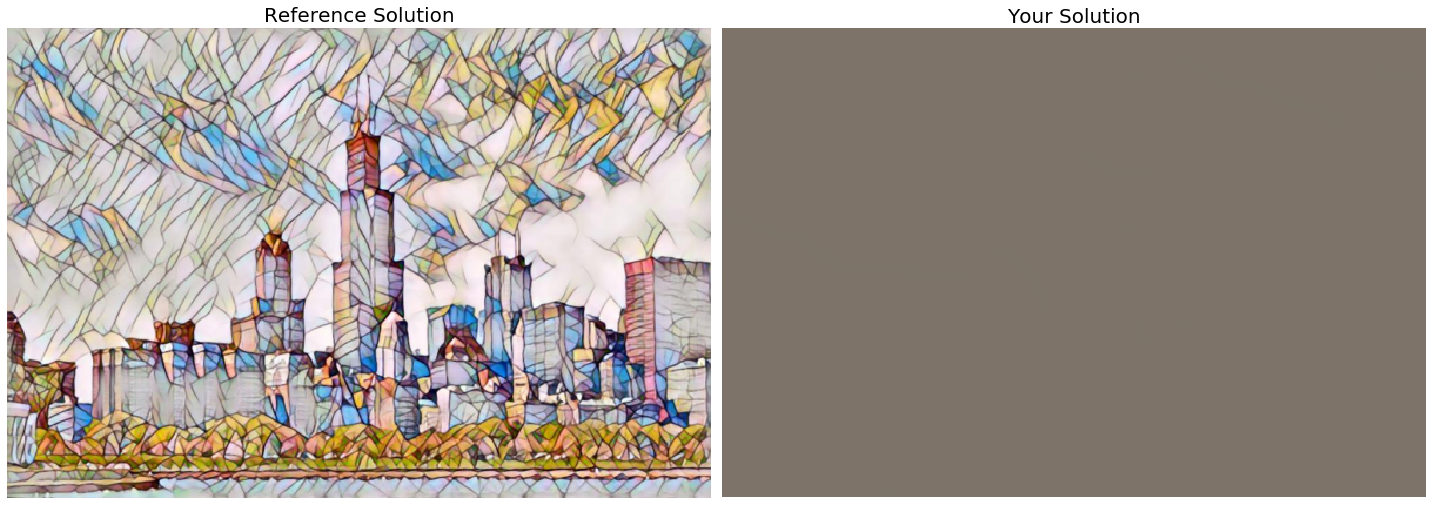

In [43]:
# Comparison to Reference Solution - Do not change anything, just execute to varify correctness of your solution

content_torch = load_image(content_img_path).to(device)

ref_output_path = os.path.join('img', 'ref', content_img_name + '_' + style_names[style_idx]  + '.jpg')
ref_output_torch = load_image(ref_output_path).to(device)

fig, axs = plt.subplots(1, 2, figsize=(20, 20))

axs[0].set_title('Reference Solution', fontsize=20)
axs[1].set_title('Your Solution', fontsize=20)

# content and correspoinding style image side-by-side
axs[0].imshow(im_convert(ref_output_torch))
axs[1].imshow(im_convert(out))

for col in range(0, 2):
    axs[col].axis('off')
        
fig.tight_layout()
plt.show()

In [22]:
coco_dir = 'MSCOCO_256x256'

train_dataset = ImageDataset(root = os.path.join(coco_dir, 'train2014'))

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = 4,
        num_workers = 0,
        shuffle = True
)


torch.Size([4, 3, 256, 256])
torch.Size([4, 64, 256, 256])
torch.Size([4, 256, 64, 64])
torch.Size([256, 256])


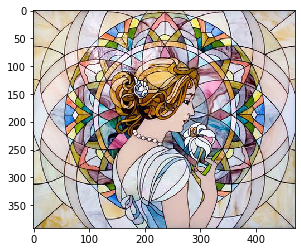

In [40]:
layers_vgg16 = {'3':'relu1_2',
                  '8':'relu2_2',
                  '15':'relu3_3',
                  '22':'relu4_3'}
style_image_path = os.path.join('img', 'style', style_names[style_idx] + '.jpg')
style_image = load_image(style_image_path).to(device)
#style_image = style_image.repeat(4,1,1,1)
plt.imshow(im_convert(style_image))
B, C, H, W = style_image.shape
style_image = style_image.expand(4, C, H, W)

style_features = get_features(style_image, vgg16, layers_vgg16)
style_grams = {layer: gram_matrix(style_features[layer], normalize = True) for layer in style_features}
model = StyleTransferNetwork().to(device)
for batch_idx, images in enumerate(train_loader):
    mytarget = images.to(device)
    print(mytarget.shape)
    target_features =  get_features(mytarget, vgg16,layers_vgg16)
    print(target_features['relu1_2'].shape)
    print(target_features['relu3_3'].shape)
    target_grams = {layer: gram_matrix(target_features[layer], normalize=True) for layer in target_features}
    print(target_grams['relu1_2'].shape)
    style_gram = style_grams['relu1_2']
    
    target_gram = target_grams['relu1_2']
    torch.add(target_gram, style_gram)
    break